In [31]:
!pip install pandas scikit-learn matplotlib seaborn plotly

  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:01:02m
Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

In [34]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

base_censo = pd.read_csv('data/adultdata.csv', names=column_names)
print("Distribuição das classes antes do balanceamento:")
print(base_censo['income'].value_counts())

Distribuição das classes antes do balanceamento:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64


In [49]:
X_censo = base_censo.iloc[:, 0:14].values
y_censo = base_censo.iloc[:, 14].values

In [50]:
label_encoder_workclass = LabelEncoder()
label_encoder_education = LabelEncoder()
label_encoder_marital = LabelEncoder()
label_encoder_occupation = LabelEncoder()
label_encoder_relationship = LabelEncoder()
label_encoder_race = LabelEncoder()
label_encoder_sex = LabelEncoder()
label_encoder_country = LabelEncoder()

X_censo[:,1] = label_encoder_workclass.fit_transform(X_censo[:,1])
X_censo[:,3] = label_encoder_education.fit_transform(X_censo[:,3])
X_censo[:,5] = label_encoder_marital.fit_transform(X_censo[:,5])
X_censo[:,6] = label_encoder_occupation.fit_transform(X_censo[:,6])
X_censo[:,7] = label_encoder_relationship.fit_transform(X_censo[:,7])
X_censo[:,8] = label_encoder_race.fit_transform(X_censo[:,8])
X_censo[:,9] = label_encoder_sex.fit_transform(X_censo[:,9])
X_censo[:,13] = label_encoder_country.fit_transform(X_censo[:,13])

In [51]:
onehotencoder_censo = ColumnTransformer(
    transformers=[('OneHot', OneHotEncoder(), [1,3,5,6,7,8,9,13])],
    remainder='passthrough'
)
X_censo = onehotencoder_censo.fit_transform(X_censo).toarray()

In [52]:
#Balanceamento
X_50k = X_censo[y_censo == '<=50K']
y_50k = y_censo[y_censo == '<=50K']
X_mais_50k = X_censo[y_censo == '>50K']
y_mais_50k = y_censo[y_censo == '>50K']

In [56]:
# Definir 30% ou o número total de amostras da classe, o que for menor
sample_size_50k = min(int(0.30 * len(y_50k)), len(y_50k))
sample_size_mais_50k = min(int(0.30 * len(y_mais_50k)), len(y_mais_50k))

# Resampling com tamanho ajustado
X_treinamento_50k, y_treinamento_50k = resample(X_50k, y_50k, replace=False, n_samples=sample_size_50k, random_state=0)
X_treinamento_mais_50k, y_treinamento_mais_50k = resample(X_mais_50k, y_mais_50k, replace=False, n_samples=sample_size_mais_50k, random_state=0)

# Conjunto de teste balanceado
X_teste_50k, y_teste_50k = resample(X_50k, y_50k, replace=False, n_samples=max(5500, 1), random_state=0)
X_teste_mais_50k, y_teste_mais_50k = resample(X_mais_50k, y_mais_50k, replace=False, n_samples=max(2500, 1), random_state=0)

# Combinar conjuntos balanceados
X_censo_treinamento = np.vstack((X_treinamento_50k, X_treinamento_mais_50k))
y_censo_treinamento = np.hstack((y_treinamento_50k, y_treinamento_mais_50k))
X_teste_final = np.vstack((X_teste_50k, X_teste_mais_50k))
y_teste_final = np.hstack((y_teste_50k, y_teste_mais_50k))

In [57]:
# 7. Normalização dos Dados
scaler = StandardScaler()
X_censo_treinamento = scaler.fit_transform(X_censo_treinamento)
X_teste_final = scaler.transform(X_teste_final)

In [58]:
# 8. Configuração do Modelo de Rede Neural
mlp_classifier = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=0)


In [59]:
# 9. Treinamento do Modelo
mlp_classifier.fit(X_censo_treinamento, y_censo_treinamento)

/Users/lailson/Documents/projetos/census/env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(64, 32), random_state=0)

In [61]:
# 10. Avaliação do Modelo
previsoes_final = mlp_classifier.predict(X_teste_final)
acuracia_final = accuracy_score(y_teste_final, previsoes_final)
print("Acurácia do modelo MLP com o conjunto de teste ajustado:", acuracia_final)


Acurácia do modelo MLP com o conjunto de teste ajustado: 0.9485


In [62]:
# 11. Exibição da Matriz de Confusão
matriz_confusao_final = confusion_matrix(y_teste_final, previsoes_final)
print("\nMatriz de Confusão:")
print(matriz_confusao_final)


Matriz de Confusão:
[[5389  111]
 [ 301 2199]]


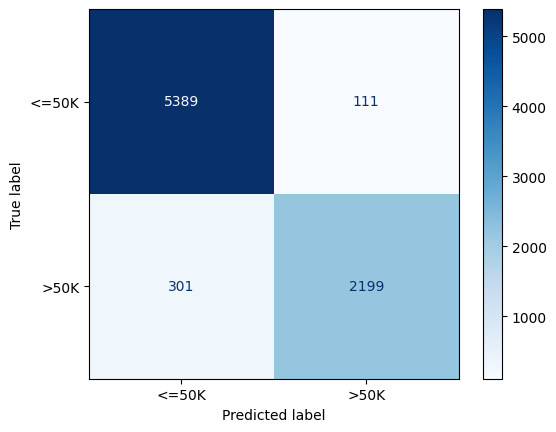

In [63]:
# Exibindo a matriz de confusão de forma gráfica
disp_final = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao_final, display_labels=mlp_classifier.classes_)
disp_final.plot(cmap="Blues")
plt.show()

In [64]:
#Relatório de Classificação
relatorio_classificacao_final = classification_report(y_teste_final, previsoes_final, target_names=['<=50K', '>50K'])
print("Relatório de Classificação:")
print(relatorio_classificacao_final)


Relatório de Classificação:
              precision    recall  f1-score   support

       <=50K       0.95      0.98      0.96      5500
        >50K       0.95      0.88      0.91      2500

    accuracy                           0.95      8000
   macro avg       0.95      0.93      0.94      8000
weighted avg       0.95      0.95      0.95      8000

